In [104]:
%matplotlib inline

In [87]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from IPython.display import Image

In [67]:
#now do some folder as input
BASEFOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp'
GENOME_FOLDER = os.path.join(BASEFOLDER, 'genomes')
OUTFOLDER = os.path.join(BASEFOLDER, 'output')
if not os.path.exists(OUTFOLDER):
    os.makedirs(OUTFOLDER)
DK0911_p = 'DK_0911_v04_p_ctg.fa'
DK0911_h = 'DK_0911_v04_h_ctg.fa'
DK0911_ph = 'DK_0911_v04_ph_ctg.fa'
PST_104E_p = 'Pst_104E_v13_p_ctg.fa'
PST_104E_h = 'Pst_104E_v13_h_ctg.fa'
PST_104E_ph = 'Pst_104E_v13_ph_ctg.fa'

In [5]:
def run_command(command):
    print('\nRunnning now!\n')
    print(command)
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print('\nDone\nWith ouput:\n%s' % output)
    #print(output)

In [116]:
def run_nucmer(ref, query,maxmatch=True, l=100, c=500):
    '''Run nucmer with three options.'''
    #print(os.path.basename(ref)[:-3])
    delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
    command='nucmer -l %s -c %s %s %s > %s' % (l, c, ref, query, delta)
    if maxmatch == True:
        delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.mm.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
        command='nucmer --maxmatch -l %s -c %s %s %s --prefix=%s' % (l, c, ref, query, delta.replace('.delta', ''))
    run_command(command)
    return delta

In [81]:
def run_delta_filter(delta, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following delta filter option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    delta_filter = delta.replace('.delta', '.deltafilter_%s' %(filter_string.replace(' ', '').replace('-','')))
    command = 'delta-filter %s % s > %s' % (filter_string, delta, delta_filter)
    run_command(command)
    return delta_filter

In [91]:
def run_show_coords(delta_filter, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following show-coords option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    #print(delta_filter.index('.delta'))
    showcoords = '%s_%s.coords' % (delta_filter[:delta_filter.index('.delta')], filter_string.replace(' ', '').replace('-',''))
    command = 'show-coords -T %s %s > %s' % (filter_string, delta_filter, showcoords)
    run_command(command)
    return showcoords

In [97]:
def run_mummerplot(delta_filter, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following mummerplot option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    mummerplot = os.path.basename(delta_filter) 
    previous_dir = os.getcwd()
    os.chdir(OUTFOLDER)
    command = 'mummerplot %s -p %s --png %s' % (filter_string, mummerplot, delta_filter)
    run_command(command)
    os.chdir(previous_dir)
    return '%s.png' % (mummerplot)

In [107]:
def show_image(mummerplot):
    previous_dir = os.getcwd()
    os.chdir(OUTFOLDER)
    Image(mummerplot)
    #os.chdir(previous_dir)

In [117]:
delta = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h))


Runnning now!

nucmer --maxmatch -l 100 -c 500 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_h_ctg.fa --prefix=/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm

Done
With ouput:
b'1: PREPARING DATA\n2,3: RUNNING mummer AND CREATING CLUSTERS\n# reading input file "/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.ntref" of length 74427711\n# construct suffix tree for sequence of length 74427711\n# (maximum reference length is 536870908)\n# (maximum query length is 4294967295)\n# process 744277 characters per dot\n#............................................

In [ ]:
delta_DK0911_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h), maxmatch=False)
delta_DK0911_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h))
delta_DK0911_Pst_104Ep_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p))
delta_DK0911_Pst_104Eph_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph))
delta_DK0911_Pst_104Ep_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p), maxmatch=False)
delta_DK0911_Pst_104Eph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph), maxmatch=False)


Runnning now!

nucmer -l 100 -c 500 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_h_ctg.fa > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.delta

Done
With ouput:
b'1: PREPARING DATA\n2,3: RUNNING mummer AND CREATING CLUSTERS\n# reading input file "out.ntref" of length 74427711\n# construct suffix tree for sequence of length 74427711\n# (maximum reference length is 536870908)\n# (maximum query length is 4294967295)\n# process 744277 characters per dot\n#....................................................................................................\n# CONSTRUCTIONTIME /home/benjamin/anaconda3/opt/mummer-3.23/mummer out.ntref 68.50\n# reading input file "/home/be

In [ ]:
delta_Pst_104E_DK0911p_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p))
delta_Pst_104E_DK0911p_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p), maxmatch=False)
delta_Pst_104E_DK0911ph_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph))
delta_Pst_104E_DK0911ph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph), maxmatch=False)
delta_Pst_104E_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h), maxmatch=False)
delta_Pst_104E_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h))


Runnning now!

nucmer --maxmatch -l 100 -c 500 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/Pst_104E_v13_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa --prefix=/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm

Done
With ouput:
b'1: PREPARING DATA\n2,3: RUNNING mummer AND CREATING CLUSTERS\n# reading input file "/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.ntref" of length 83355772\n# construct suffix tree for sequence of length 83355772\n# (maximum reference length is 536870908)\n# (maximum query length is 4294967295)\n# process 833557 characters per dot\n#.........................................

In [131]:
delta_filters = {'m':'-m'}
delta_filters = {}
show_coords_filter = {'l': '-l', 'r': '-r'}

mummerplot_filter = {'c': '-c', 'r': '-r pcontig_000'}

In [132]:
delta_filter = run_delta_filter(delta, **delta_filters)


Runnning now!

delta-filter  /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_

Done
With ouput:
b''
b''


In [120]:
showcoords = run_show_coords(delta_filter, **show_coords_filter)

Used following show-coords option: r -r
Used following show-coords option: l -l

Runnning now!

show-coords -T  -r -l /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm_rl.coords

Done
With ouput:
b''
b''


In [133]:
mummer_plot = run_mummerplot(delta_filter, **mummerplot_filter)

Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_ --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_

Done
With ouput:
b'gnuplot 4.6 patchlevel 6\nReading delta file /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_\nWriting plot files DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.fplot, DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.rplot\nWriting gnuplot script DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.gp\nRendering plot DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.png\n'
b'gnuplot 4.6 patchlevel 6\nReading delta file /h

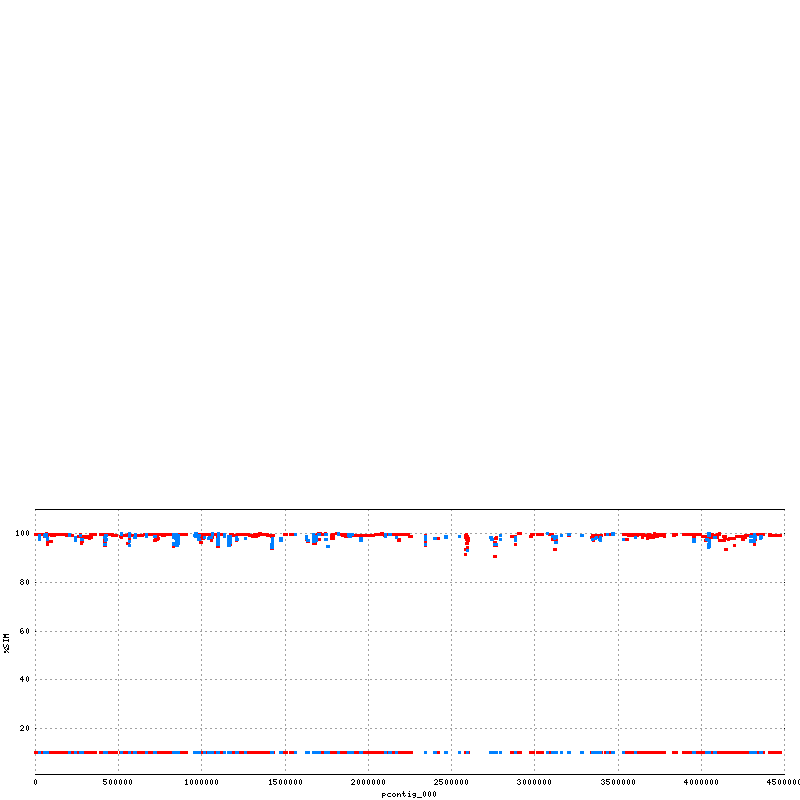

In [134]:
previous_dir = os.getcwd()
os.chdir(OUTFOLDER)
Image(mummer_plot)
#os.chdir(previous_dir)